In [12]:
import analyse
import MDAnalysis as mda
import matplotlib.pyplot as plt
import MDAnalysis.analysis.rms as rms

In [13]:
PDB_CODE = '4djh'
SEQ = 'A'
folder = '../'+PDB_CODE+SEQ+'/'

In [14]:
trajectory =  mda.Universe(folder+'step5_assembly.xplor_ext.psf', folder+'namd/step7.1_production.dcd')
ref = mda.Universe(folder+'4djh_inp.pdb')

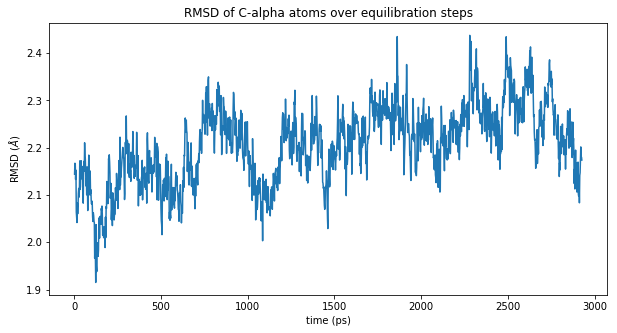

In [15]:
R = analyse.rmsd_traj(trajectory, ref, plot=True)

In [16]:
first_frame = trajectory.select_atoms('name CA').positions[0]

In [17]:
R = rms.RMSD(trajectory.select_atoms('name CA'), first_frame).run()
R = R.rmsd.T
frame = R[0]
time = R[1]

plt.figure(figsize=(10,5))
plt.plot(time, R[2])
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('time (ps)')
plt.title('RMSD of C-alpha atoms over equilibration steps')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'select_atoms'

In [18]:
pdb_file = folder+'4djh_inp.pdb'
struct = analyse.secondary_structure(pdb_file)

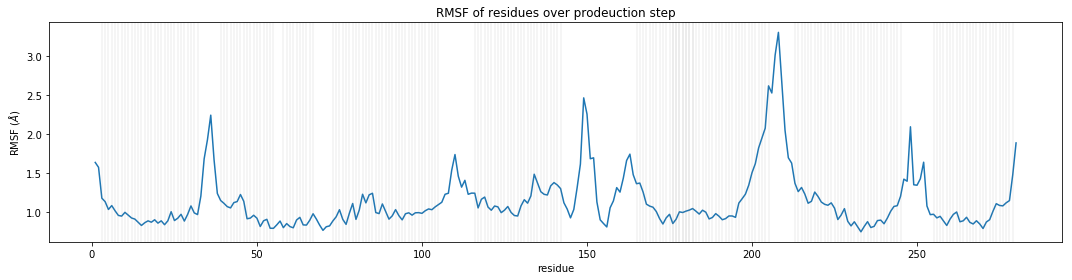

In [19]:
analyse.rmsf_plot([trajectory], title='RMSF of residues over prodeuction step', structure=struct)

In [ ]:
import MDAnalysis.analysis.hbonds

h = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(trajectory, 'protein', 'name TIP3P', distance=3.0, angle=120.0)
h.run()